In [ ]:
# default_exp dataset.loader

In [ ]:
# export
from PIL import Image
import os
import os.path
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np

In [ ]:
#export
FILENAMES = {'train': ['class_tripletlist_train.txt', 'closure_tripletlist_train.txt', 
                'gender_tripletlist_train.txt', 'heel_tripletlist_train.txt'],
             'val': ['class_tripletlist_val.txt', 'closure_tripletlist_val.txt', 
                'gender_tripletlist_val.txt', 'heel_tripletlist_val.txt'],
             'test': ['class_tripletlist_test.txt', 'closure_tripletlist_test.txt', 
                'gender_tripletlist_test.txt', 'heel_tripletlist_test.txt']}

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset):
    def __init__(self, root, base_path, json_file, conditions, split, n_triplets, transform=None,
                 loader=default_image_loader):
        """ json_file: A text file with each line containing the path to an image e.g.,
                images/class1/sample.jpg
            triplets_file_name: A text file with each line containing three integers, 
                where integer i refers to the i-th image in the FILENAMES file. 
                For a line of intergers 'a b c', a triplet is defined such that image a is more 
                similar to image c than it is to image b, e.g., 
                0 2017 42 """
        self.root = root
        self.base_path = base_path  
        self.filenamelist = []
        for line in open(os.path.join(self.root, json_file)):
            self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        if split == 'train':
            fnames = FILENAMES['train']
        elif split == 'val':
            fnames = FILENAMES['val']
        else:
            fnames = FILENAMES['test']
        for condition in conditions:
            for line in open(os.path.join(self.root, 'tripletlists', fnames[condition])):
                triplets.append((line.split()[0], line.split()[1], line.split()[2], condition)) # anchor, far, close   
        # print(triplets[:100])   
        np.random.shuffle(triplets)
        # print(triplets[:100])  
#         self.triplets = triplets[:int(n_triplets * 1.0 * len(conditions) / 4)] #Not sure about the importance 
        self.triplets = triplets[:int(n_triplets)]
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3, c = self.triplets[index]
        if os.path.exists(os.path.join(self.root, self.base_path, self.filenamelist[int(path1)])) and os.path.exists(os.path.join(self.root, self.base_path, self.filenamelist[int(path2)])) and os.path.exists(os.path.join(self.root, self.base_path, self.filenamelist[int(path3)])):
#             open each of the images and transform/augment them
            img1 = self.loader(os.path.join(self.root, self.base_path, self.filenamelist[int(path1)]))
            img2 = self.loader(os.path.join(self.root, self.base_path, self.filenamelist[int(path2)]))
            img3 = self.loader(os.path.join(self.root, self.base_path, self.filenamelist[int(path3)]))
            if self.transform is not None:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
                img3 = self.transform(img3)
            return img1, img2, img3, c
        else:
            return None

    def __len__(self):
        return len(self.triplets)

Exploration

In [ ]:
#hide
os.path.exists(os.path.join('data', 'ut-zap50k-images'))

True

In [ ]:
#hide
triplets_set = os.path.join('data', 'tripletlists')
data = os.path.join('data', 'ut-zap50k-images')
json_file = os.path.join('data', 'filenames.json')

In [ ]:
#hide
filenamelist = []
for line in open(json_file):
    filenamelist.append(line.rstrip('\n'))
filenamelist[:10]

['Shoes/Oxfords/Bostonian/100627.72.jpg',
 'Shoes/Oxfords/Bostonian/100627.255.jpg',
 'Shoes/Oxfords/Bostonian/100657.72.jpg',
 'Shoes/Oxfords/Bostonian/100657.216.jpg',
 'Boots/Mid-Calf/Durango/101026.3.jpg',
 'Sandals/Heel/Finn Comfort/101093.316189.jpg',
 'Sandals/Heel/Finn Comfort/101093.316195.jpg',
 'Sandals/Heel/Finn Comfort/101093.316313.jpg',
 'Sandals/Heel/Finn Comfort/101093.342648.jpg',
 'Boots/Mid-Calf/Frye/101175.325.jpg']

In [ ]:
#hide
fnames = FILENAMES['train']; print(fnames)

['class_tripletlist_train.txt', 'closure_tripletlist_train.txt', 'gender_tripletlist_train.txt', 'heel_tripletlist_train.txt']


The conditions should be a size 4 list of ints which represent one of the conditions in the `fnames` list

In [ ]:
#hide
conditions = [0, 1 ,2 ,3]

Let's understand what the condition 'class' means

In [ ]:
#hide
import matplotlib.pyplot as plt

In [ ]:
#hide
# condit = 'class closure gender heel'

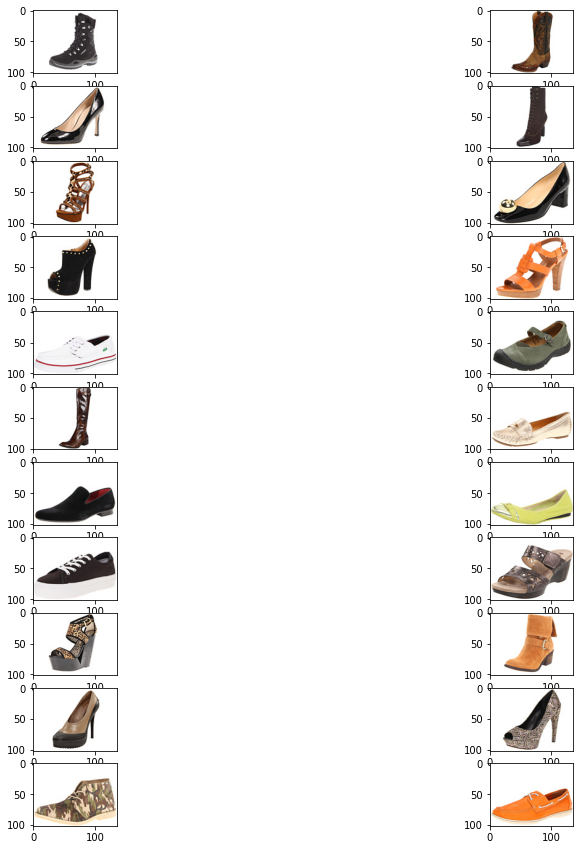

In [ ]:
#hide
condition_ = 3
sub = []
_, ax = plt.subplots(11, 2, figsize=(15, 15))
for i, line in enumerate(open(os.path.join(triplets_set, fnames[condition_]))):
    sub.append((line.split()[0], line.split()[1], line.split()[2], condition))
    ax[i][0].imshow(np.array(Image.open(os.path.join(data, filenamelist[int(line.split()[0])]))))
    ax[i][1].imshow(np.array(Image.open(os.path.join(data, filenamelist[int(line.split()[2])]))))

    if i == 10: break

In [ ]:
#hide
triplets = []
for condition in conditions:
    for line in open(os.path.join(triplets_set, fnames[condition])):
        triplets.append((line.split()[0], line.split()[1], line.split()[2], condition))

In [ ]:
#hide
# anchor, positve, negative and the similarity condition(which acts as our label)
triplets[:5]

[('43254', '13267', '37915', 0),
 ('22308', '23254', '11407', 0),
 ('43523', '8723', '17885', 0),
 ('47104', '3176', '25252', 0),
 ('42758', '18241', '32579', 0)]

In [ ]:
#hide
len(triplets)

800000

We can choose however number of triplets we want to use from the 800000. Will drop all the ones that were not chosen

In [ ]:
#hide
n_triplets = 100000

In [ ]:
#hide
np.random.shuffle(triplets)
all_triplets = triplets[:int(n_triplets * 1.0 * len(conditions) / 4)]
len(all_triplets)

100000

In [ ]:
#hide
all_triplets[-10:]

[('10464', '27045', '3341', 2),
 ('39940', '28686', '34617', 1),
 ('29161', '20508', '22530', 1),
 ('49077', '4071', '11610', 0),
 ('11287', '14500', '19026', 2),
 ('37703', '16579', '17591', 0),
 ('29430', '9992', '8493', 2),
 ('25584', '42806', '18151', 2),
 ('24660', '42703', '20029', 3),
 ('14321', '38925', '32385', 2)]

In [ ]:
#hide
all_triplets[0], filenamelist[int(all_triplets[0][0])]

(('43254', '13267', '37915', 0), 'Boots/Knee High/Steven/8058457.72.jpg')

In [ ]:
#hide
from PIL import Image

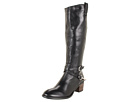

In [ ]:
#hide
Image.open(os.path.join(data, filenamelist[int(all_triplets[][0])]))

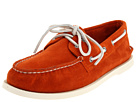

In [ ]:
#hide
Image.open(os.path.join(data, filenamelist[int(all_triplets[0][1])]))